# Exploring Automotive Engine Health

![`Automotive_Engine`](https://api.ferrari.com/cms/network/medias//resize/637f5d201a2ca00024d2f430-1889903_1920x1080?apikey=9QscUiwr5n0NhOuQb463QEKghPrVlpaF)

## Necessary Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

## Loading the Dataset

In [2]:
engine_df = pd.read_csv("../input/automotive-vehicles-engine-health-dataset/engine_data.csv")
engine_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


## Exploratory Data Analysis

In [3]:
engine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


In [4]:
engine_df.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000


In [5]:
engine_df["Engine Condition"].value_counts()

Engine Condition
1    12317
0     7218
Name: count, dtype: int64

**`Important`**
- There is binary encoding to the target variable
- `0`: Bad Condition
- `1`: Good Condition

**`Seperating the Features and Targets`**

In [6]:
engine_features = engine_df.drop("Engine Condition", axis=1)
engine_labels = engine_df["Engine Condition"]

**`Visualising the Distribution of all the Attributes`**

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


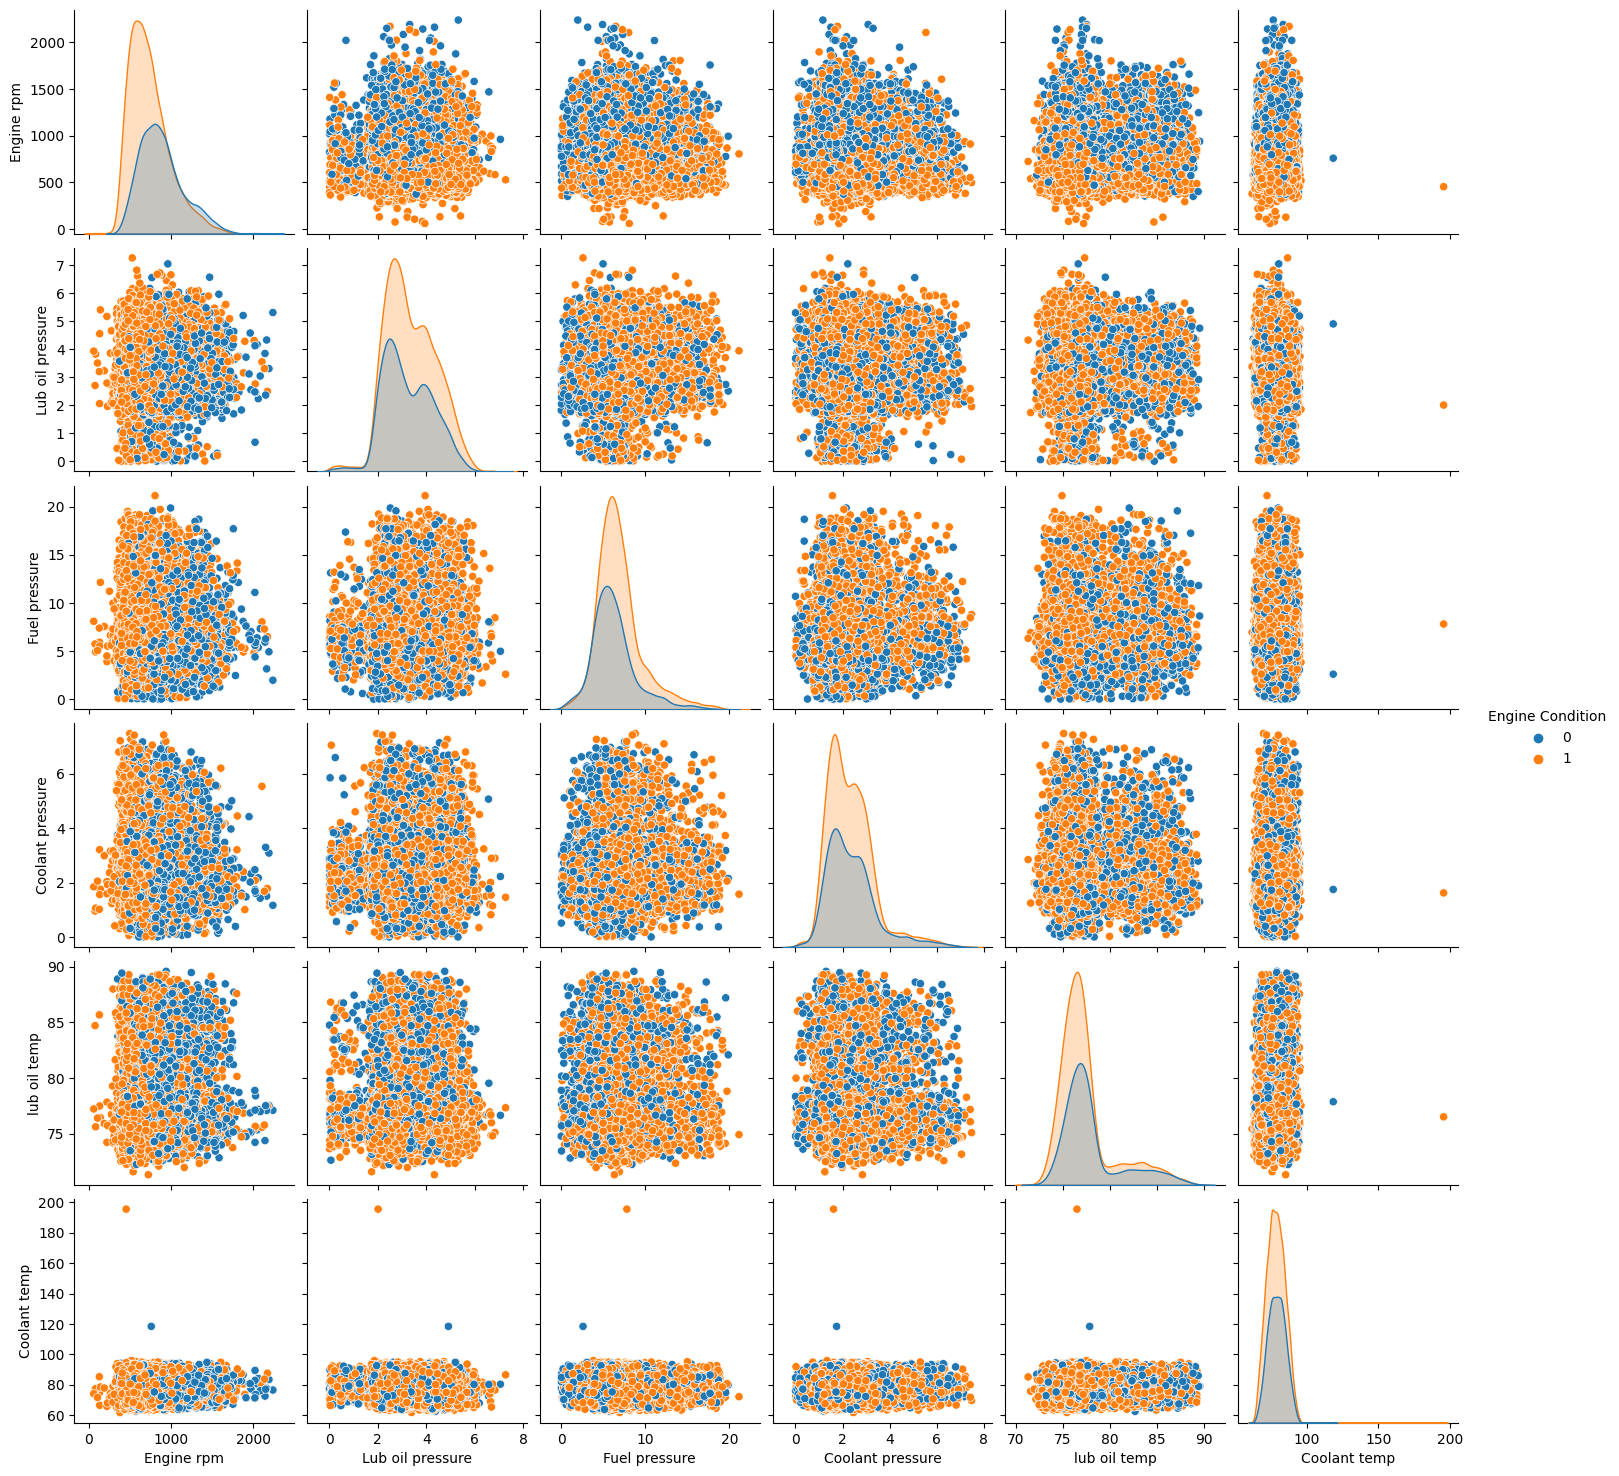

In [7]:
sns.pairplot(engine_df, hue="Engine Condition")

**`Inference`**
- Most of the attributes provided by the dataset are well distributed with respect to all the columns
- `Coolant Temp` needs to be scaled to make its distribution more uniform

**`Calculating the Correlation Coefficient`**

In [8]:
corr_matrix = engine_df.corr()
corr_matrix["Engine Condition"].sort_values(ascending=False)

Engine Condition    1.000000
Fuel pressure       0.116259
Lub oil pressure    0.060904
Coolant pressure   -0.024054
Coolant temp       -0.046326
lub oil temp       -0.093635
Engine rpm         -0.268201
Name: Engine Condition, dtype: float64

**`Inference`**
- `Engine Condition` has the highest **positive** correlation with `Fuel Pressure`
- `Engine Condition` has the highest **negative** correlation with `Engine RPM`

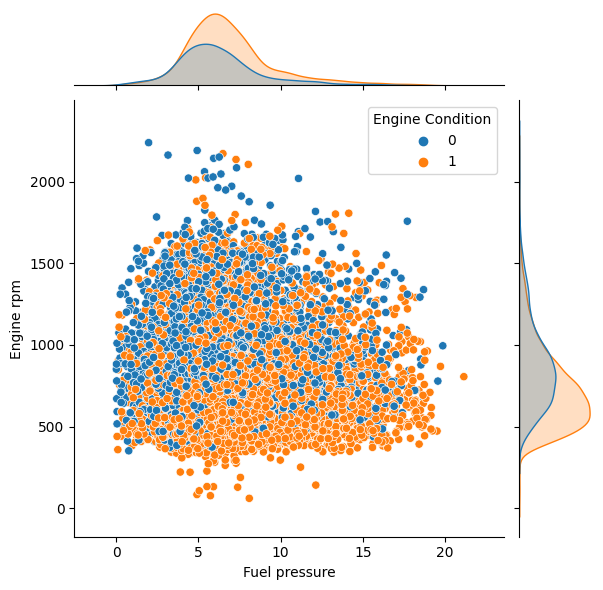

In [9]:
sns.jointplot(engine_df, x="Fuel pressure", y="Engine rpm", hue="Engine Condition")

**`Verification - 1`**
- We can verify that for higher/consistent values of `Fuel Pressure` and low values of `Engine rpm` the `Engine Condition` is positive

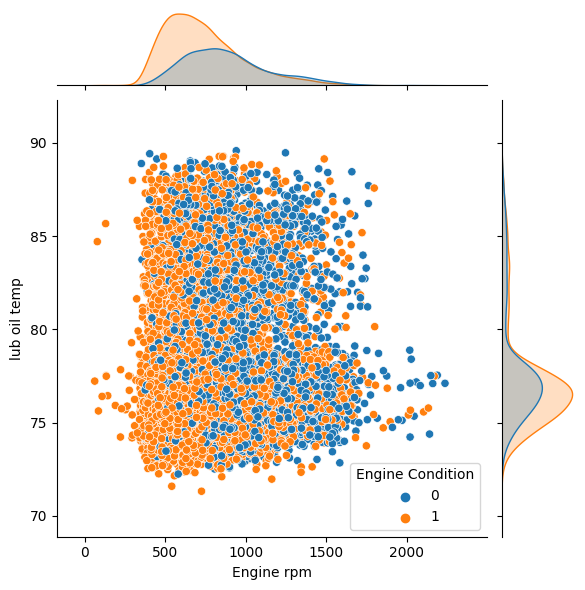

In [10]:
sns.jointplot(engine_df, x="Engine rpm", y="lub oil temp", hue="Engine Condition")

**`Important`**
- Most of the the `Orange` datapoints indicating a Positive `Engine Condition` are on the left side

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


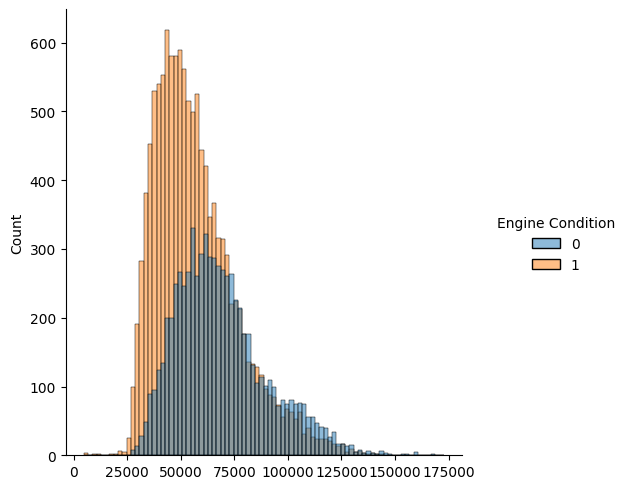

In [11]:
sns.displot(engine_df, x=engine_df["Engine rpm"] * engine_df["lub oil temp"], hue="Engine Condition")

**`Verification - 2`**
- We can verify that for lower/consistent values of `Engine RPM` and `Lub oil temp` the `Engine Condition` is positive

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


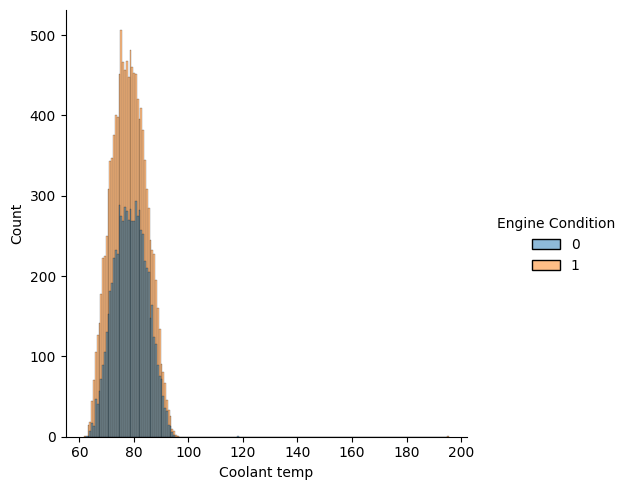

In [12]:
sns.displot(engine_df, x="Coolant temp", hue="Engine Condition")

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


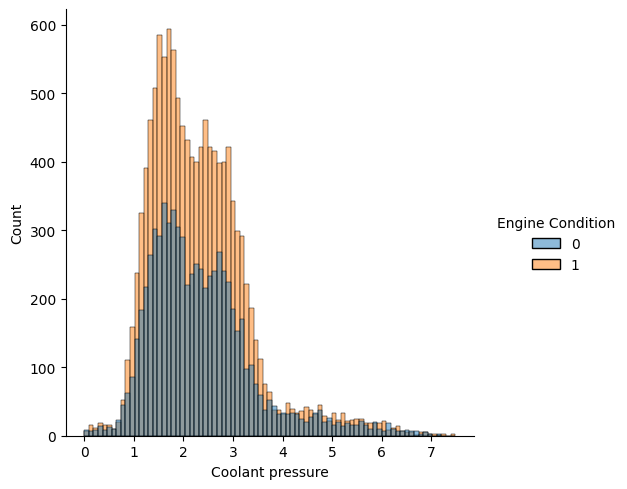

In [13]:
sns.displot(engine_df, x="Coolant pressure", hue="Engine Condition")

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


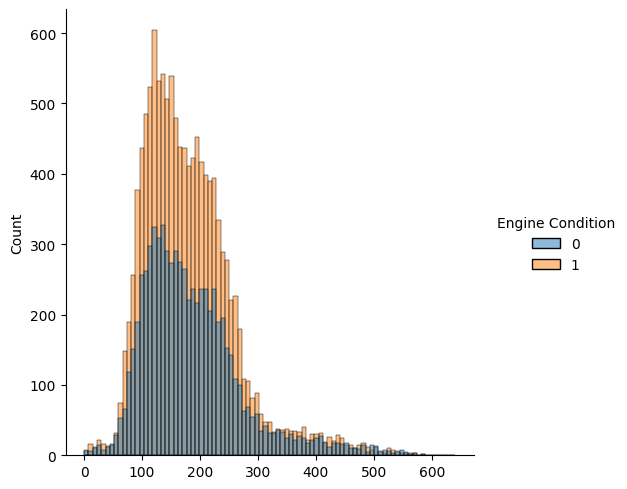

In [14]:
sns.displot(engine_df, x=engine_df["Coolant pressure"] * engine_df["Coolant temp"], hue="Engine Condition")

**`Inference`**
- We can see that there is a uniform distribution of `Positive and Negative` Engine conditions for diifferent values of `Coolant Pressure` and `Coolant Temperature`

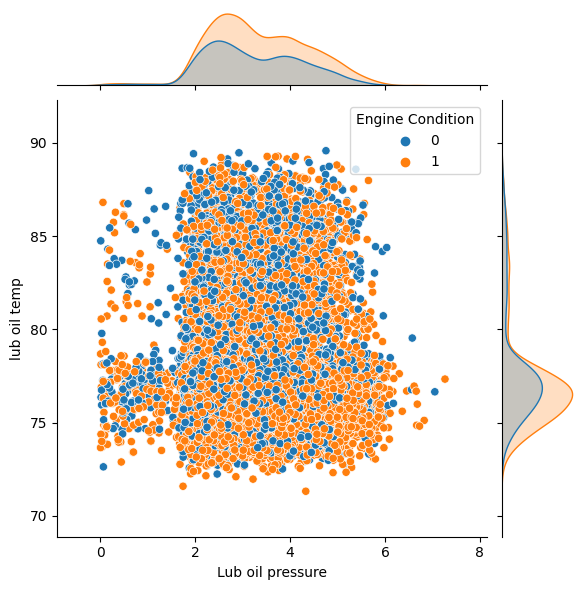

In [15]:
sns.jointplot(engine_df, x="Lub oil pressure", y="lub oil temp", hue="Engine Condition")

**`Inference`**
- As seen in the KDE
    - `Lub Oil Pressure` has a `direct relationship` with `Engine Condition`
    - `Lub Oil Temperature` has an `inverse relationship` with `Engine Condition`

## Trying New Attributes (Feature Engineering)

In [16]:
# Oiling system
# engine_df["Oil System"] = engine_df["Lub oil pressure"] * engine_df["lub oil temp"]

# Coolant System
# engine_df["Coolant System"] = engine_df["Coolant pressure"] * engine_df["Coolant temp"]

# Coolant Efficiency
engine_df["Coolant Efficiency"] = (1 / engine_df["Engine rpm"]) * engine_df["Coolant temp"]

# Oil Efficiency
engine_df["Oil Efficiency"] = 1 / (engine_df["Engine rpm"] * engine_df["lub oil temp"])

engine_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition,Coolant Efficiency,Oil Efficiency
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1,0.116617,0.000017
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0,0.094116,0.000015
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1,0.153165,0.000025
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1,0.151743,0.000029
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0,0.140550,0.000021


**`Calculating the Correlations with the New Attributes`**

In [17]:
corr_matrix = engine_df.corr()
corr_matrix["Engine Condition"].sort_values(ascending=False)

Engine Condition      1.000000
Oil Efficiency        0.274301
Coolant Efficiency    0.252389
Fuel pressure         0.116259
Lub oil pressure      0.060904
Coolant pressure     -0.024054
Coolant temp         -0.046326
lub oil temp         -0.093635
Engine rpm           -0.268201
Name: Engine Condition, dtype: float64

**`Inference`**
- `Oil Efficiency` and `Coolant Efficiency` have high positive correlation to a `Positive Engine Condition`

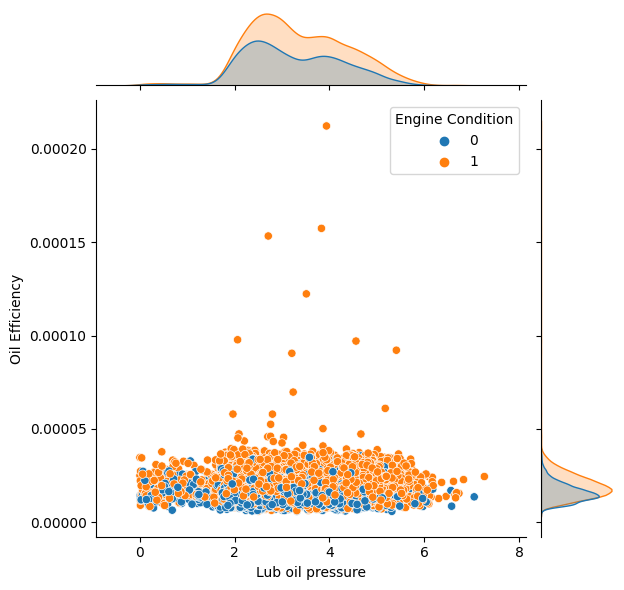

In [18]:
sns.jointplot(engine_df, x="Lub oil pressure", y="Oil Efficiency", hue="Engine Condition")

**`Inference`**
- As the Oil Efficiency increases the Engine Condition is mostly positive
- The Lub Oil Pressure has a mostly uniform distribution over the entire range of values

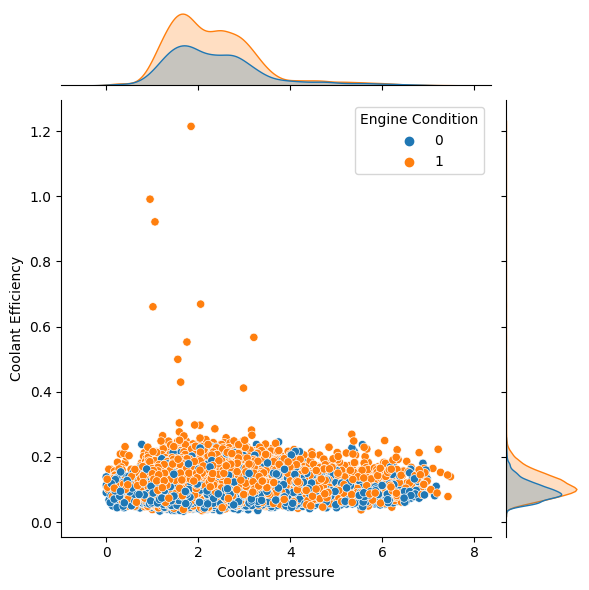

In [19]:
sns.jointplot(engine_df, x="Coolant pressure", y="Coolant Efficiency", hue="Engine Condition")

**`Inference`**
- As the Coolant Efficiency increases the Engine Condition is mostly positive
- The Coolant Pressure has a mostly uniform distribution over the entire range of values

## Note
- There may be scope for more Data Analysis and Visualisation
- This was the best I could think of at this point
- Please leave comments on anymore ideas for Data Analysis or Feature Engineering

## Data Preprocessing

**`Building a Custom Transformer to add the new attibutes`**

In [20]:
rpm_idx, oil_pressure_idx, coolant_pressure_idx, oil_temp_idx, coolant_temp_idx = 0, 1, 3, 4, 5

class AttributesAdder(BaseEstimator, TransformerMixin):
    
    # Constructor of the Class
    def __init__(self, add_oil_system=True, add_coolant_system=True):
        self.add_oil_system = add_oil_system
        self.add_coolant_system = add_coolant_system
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_oil_system:
            # oil_system = X[:, oil_pressure_idx] * X[:, oil_temp_idx]
            oil_efficiency = 1 / (X[:, rpm_idx] * X[:, oil_temp_idx])
            # X = np.c_[X, oil_system, oil_efficiency]
            X = np.c_[X, oil_efficiency]
            
        if self.add_coolant_system:
            # cool_system = X[:, coolant_pressure_idx] * X[:, coolant_temp_idx]
            cool_efficiency = (1 / X[:, rpm_idx]) * X[:, coolant_temp_idx]
            # X = np.c_[X, cool_system, cool_efficiency]
            X = np.c_[X, cool_efficiency]
            
        return X      

In [21]:
engine_features.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,700,2.493592,11.790927,3.178981,84.144163,81.632187
1,876,2.941606,16.193866,2.464504,77.640934,82.445724
2,520,2.961746,6.553147,1.064347,77.752266,79.645777
3,473,3.707835,19.510172,3.727455,74.129907,71.774629
4,619,5.672919,15.738871,2.052251,78.396989,87.000225


In [22]:
attr_addr = AttributesAdder()
engine_prep = attr_addr.transform(engine_features.values)
print(f"Transformed Data: {engine_prep[0, :]}")

Transformed Data: [7.00000000e+02 2.49359182e+00 1.17909274e+01 3.17898079e+00
 8.41441629e+01 8.16321865e+01 1.69776652e-05 1.16617409e-01]


**`Building the Pipeline to Automate Data Preprocessing`**

In [23]:
engine_prep_pipe = Pipeline([
    ("attr_adder", AttributesAdder()),
    ("std_scaler", StandardScaler())
])

engine_data_prepared = engine_prep_pipe.fit_transform(engine_features.values)
engine_data_prepared[0, :]

array([-0.34094836, -0.7930403 ,  1.85998007,  0.81401782,  2.08966341,
        0.51634686, -0.18711723,  0.15814015])

In [24]:
engine_data_prepared.shape

(19535, 8)

**`Splitting the Prepared Dataset`**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(engine_data_prepared, engine_labels, test_size=0.1, random_state=42)
print(f"Shape X Train: {X_train.shape}")
print(f"Shape y Train: {y_train.shape}\n")
print(f"Shape X Test: {X_test.shape}")
print(f"Shape y Test: {y_test.shape}\n")

Shape X Train: (17581, 8)
Shape y Train: (17581,)

Shape X Test: (1954, 8)
Shape y Test: (1954,)



## Applying Machine Learning Models

**`Applying Logistic Regression`**

In [26]:
# Initilisation
log_reg = LogisticRegression()

# Training
log_reg.fit(X_train, y_train)

validation = log_reg.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.6494370522006141


**`Applying Decision Tree Classification`**

In [27]:
# Initilisation
tree_cls = DecisionTreeClassifier()

# Training
tree_cls.fit(X_train, y_train)

validation = tree_cls.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.579324462640737


**`Applying Random Forest Classification`**

In [28]:
# Initilisation
forest_cls = RandomForestClassifier()

# Training
forest_cls.fit(X_train, y_train)

validation = forest_cls.predict(X_test)
score = sum(validation == y_test)
print(f"Score: {score / len(y_test)}")

Score: 0.6351074718526101


## Model Fine Tuning

In [29]:
# param_grid = [
#     {
#         "n_estimators":[500, 1000, 1500, 2000],
#         "max_features":[4, 8, 12, 16]
#     }
# ]

# # Initialising Grid Search
# grid_search = GridSearchCV(forest_cls, param_grid, scoring="accuracy", cv=5)
# grid_search.fit(X_train, y_train)

In [30]:
# Validating Grid Search
# print(f"Best Estimator: {grid_search.best_estimator_}")
# print(f"Best Parameters: {grid_search.best_parameters_}")

In [31]:
# Loading the Best Model
# final_model = grid_search.best_estimator_

# # Making Predictions
# predictions = final_model.predict(X_test)

# # Score
# score = sum(predictions == y_test)
# print(f"Score: {score / len(y_test)}")

## Thank you for viewing my notebook 🙂🙃
**Kindly show appreciation if you liked my notebook or found it interesting**

**Though I have come to the end of my notebook anyone can do the following to make it better**
- There is scope for Model Fine Tuning using F1 Score and Hyperparameter Tuning.
- There is also scope for more Feature Engineering.